# Implementing logistic regression from scratch

In [1]:
#Libraries Import
import json
import string
import numpy as np
import pandas as pd
from math import exp
from math import sqrt
import matplotlib.pyplot as plt
pd.set_option("Chained_Assignment",None)

In [2]:
#read dataframe
dataframe=pd.read_csv("amazon_baby_subset.csv")

In [3]:
print ('# of positive reviews =', len(dataframe[dataframe['sentiment']==1]))
print ('# of negative reviews =', len(dataframe[dataframe['sentiment']==-1]))

# of positive reviews = 26579
# of negative reviews = 26493


In [4]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [5]:
#replace null values with empty string
dataframe = dataframe.fillna({'review':''})

In [6]:
#remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator) 

dataframe["review_without_punctuation"] = dataframe['review'].apply(lambda x : remove_punctuation(x))
dataframe=dataframe[["name","review_without_punctuation","rating"]]

In [7]:
# For each word in important_words, we compute a count for the number of times the word occurs in the review.
for word in important_words:
    dataframe[word] = dataframe['review_without_punctuation'].apply(lambda s : s.split().count(word))

In [8]:
dataframe['sentiment'] = dataframe['rating'].apply(lambda rating : +1 if rating > 3 else -1)

# QUIZ Implementing logistic regression from scratch

#### Question 1
How many reviews in amazon_baby_subset.gl contain the word perfect?

__Ans__:

In [9]:
len(dataframe[dataframe["perfect"]>=1])

2955

In [10]:
def get_numpy_data(dataframe,features,label):
    dataframe['intercept'] = 1
    features = ['intercept'] + features
    feature_matrix = dataframe[features].values
    label_array=dataframe[label].values
    return(feature_matrix, label_array)

In [11]:
feature_matrix, sentiment = get_numpy_data(dataframe, important_words, 'sentiment') 

#### Question 2
Consider the feature_matrix that was obtained by converting our data to NumPy format.         
How many features are there in the feature_matrix?

In [12]:
feature_matrix.shape

(53072, 194)

__Ans__: 194

#### Question 3

Assuming that the intercept is present, how does the number of features in feature_matrix relate to the number of features in the logistic regression model? Let x = [number of features in feature_matrix] and y = [number of features in logistic regression model].

__Ans__: y = x

#### Question 4
Run your logistic regression solver with provided parameters.       
As each iteration of gradient ascent passes, does the log-likelihood increase or decrease?

In [13]:
'''
feature_matrix: N * D
coefficients: D * 1
score: N * 1

predictions: N * 1

produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients) 
    predictions = 1.0/(1+np.exp(-score)) 
    return predictions

'''
errors: N * 1
feature: N * 1
derivative: 1 
'''

def feature_derivative(errors, feature):     
    derivative = np.dot(np.transpose(errors), feature)
    return derivative

def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores)))
    return lp



def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    plot_values=[]
    coefficients = np.array(initial_coefficients)
    for itr in range(max_iter):

        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==+1)
        errors = np.transpose(np.array([indicator])) - predictions

        for j in range(len(coefficients)): # loop over each coefficient

            derivative = feature_derivative(errors, feature_matrix[:,j])

            coefficients[j] += step_size*derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
        plot_values.append([itr,lp])
    return coefficients,plot_values

In [14]:
coefficients,plot_values = logistic_regression(feature_matrix, sentiment, initial_coefficients=np.zeros((194,1)),
                                   step_size=1e-7, max_iter=301)

iteration   0: log likelihood of observed labels = -36780.91768478
iteration   1: log likelihood of observed labels = -36775.13434712
iteration   2: log likelihood of observed labels = -36769.35713564
iteration   3: log likelihood of observed labels = -36763.58603240
iteration   4: log likelihood of observed labels = -36757.82101962
iteration   5: log likelihood of observed labels = -36752.06207964
iteration   6: log likelihood of observed labels = -36746.30919497
iteration   7: log likelihood of observed labels = -36740.56234821
iteration   8: log likelihood of observed labels = -36734.82152213
iteration   9: log likelihood of observed labels = -36729.08669961
iteration  10: log likelihood of observed labels = -36723.35786366
iteration  11: log likelihood of observed labels = -36717.63499744
iteration  12: log likelihood of observed labels = -36711.91808422
iteration  13: log likelihood of observed labels = -36706.20710739
iteration  14: log likelihood of observed labels = -36700.5020

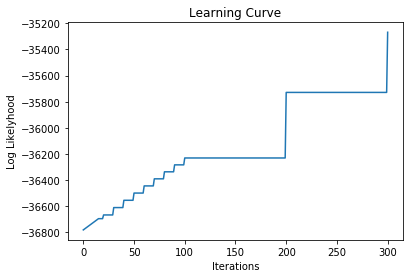

In [15]:
plt.plot([x[0] for x in plot_values],[x[1] for x in plot_values])
plt.title("Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("Log Likelyhood")

plt.show()

__Ans__: It increases.

#### Question 5
We make predictions using the weights just learned.     
How many reviews were predicted to have positive sentiment?

In [16]:
np.asarray(predict_probability(feature_matrix,coefficients) >= 0.5,dtype=int).sum()

25126

#### Question 6
What is the accuracy of the model on predictions made above? (round to 2 digits of accuracy)

__Ans__:

In [17]:
sentiment=np.asarray(sentiment>0,dtype=int)
predictions=np.asarray(predict_probability(feature_matrix,coefficients) >= 0.5,dtype=int)
predictions=np.asarray([x[0] for x in predictions])
correct_classified=np.asarray(predictions==sentiment,dtype=int).sum()
total=len(sentiment)
print("Accuracy: ",round(correct_classified/total,2))

Accuracy:  0.75


#### Question 7
We look at "most positive" words, the words that correspond most strongly with positive reviews.
Which of the following words is not present in the top 10 "most positive" words?

__Ans__: 

In [18]:
coefficients = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
word_coefficient_tuples[:10]

[('great', array([0.06654608])),
 ('love', array([0.06589076])),
 ('easy', array([0.06479459])),
 ('little', array([0.04543563])),
 ('loves', array([0.0449764])),
 ('well', array([0.030135])),
 ('perfect', array([0.02973994])),
 ('old', array([0.02007754])),
 ('nice', array([0.01840871])),
 ('daughter', array([0.0177032]))]

#### Question 8

Similarly, we look at "most negative" words, the words that correspond most strongly with negative reviews.
Which of the following words is not present in the top 10 "most negative" words?

__Ans__:

In [19]:
word_coefficient_tuples[-10:]

[('monitor', array([-0.0244821])),
 ('return', array([-0.02659278])),
 ('back', array([-0.0277427])),
 ('get', array([-0.02871155])),
 ('disappointed', array([-0.02897898])),
 ('even', array([-0.03005125])),
 ('work', array([-0.03306952])),
 ('money', array([-0.03898204])),
 ('product', array([-0.04151103])),
 ('would', array([-0.05386015]))]